In [1]:
# If not already installed, uncomment the next line:
# !pip install networkx matplotlib pandas nltk

import os
import glob
import re
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# NLTK stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\neelb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
discord_data_folder = r'C:\Users\neelb\Desktop\MEDD8925 - Analyzing Data Quantitatively\MEDD8925 Discord Project\Cleaned Discord Data'
refined_keywords_file = r'C:\Users\neelb\Desktop\MEDD8925 - Analyzing Data Quantitatively\MEDD8925 Discord Project\filtered_keywords_cleaned.csv'

In [3]:
def read_all_texts(folder):
    texts = []
    for filepath in glob.glob(os.path.join(folder, '*.txt')):
        with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
            texts.append(f.read())
    return texts

def read_keywords_from_csv(filepath):
    df = pd.read_csv(filepath)
    # First column is assumed to contain the keywords
    return set(df.iloc[:, 0].dropna().astype(str).str.lower())

In [4]:
# Read the first few keywords from the CSV file to verify
df_keywords = pd.read_csv(refined_keywords_file)
print("First 10 keywords from the first column of the CSV:")
print(df_keywords.iloc[:10, 0].tolist())

First 10 keywords from the first column of the CSV:
['aa', 'aaah', 'aaahhh', 'aboutn', 'abs', 'abt', 'abusing', 'accent', 'accountn', 'accounts']


In [5]:
discord_texts = read_all_texts(discord_data_folder)
urban_slangs = read_keywords_from_csv(refined_keywords_file)
stopwords_set = set(stopwords.words('english'))

print(f"Loaded {len(discord_texts)} Discord text files")
print(f"Loaded {len(urban_slangs)} refined keywords (slang terms)")
print(f"Loaded {len(stopwords_set)} NLTK stopwords")

Loaded 736 Discord text files
Loaded 2721 refined keywords (slang terms)
Loaded 198 NLTK stopwords


In [6]:
def simple_tokenize(text):
    return re.findall(r"\b\w[\w']*\b", text.lower())

all_tokens = []
for text in discord_texts:
    tokens = [t for t in simple_tokenize(text) if t not in stopwords_set and len(t) > 1]
    all_tokens.extend(tokens)

print("Sample tokens:", all_tokens[:20])

Sample tokens: ['guess', 'need', 'hide', 'gender', 'againn', 'yo', 'monxnhow', 'tf', 'handle', 'period', 'cramps', 'thing', 'ofc', 'cramps', 'hug', 'lay', 'warm', 'pad', 'ur', 'tummy']


In [7]:
WINDOW_SIZE = 4
G = nx.Graph()

for i in range(len(all_tokens) - WINDOW_SIZE):
    window = all_tokens[i:i+WINDOW_SIZE]
    for j in range(len(window)):
        for k in range(j+1, len(window)):
            w1, w2 = window[j], window[k]
            if w1 != w2:
                if G.has_edge(w1, w2):
                    G[w1][w2]['weight'] += 1
                else:
                    G.add_edge(w1, w2, weight=1)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 3354222 nodes and 82280087 edges.


In [8]:
pagerank_scores = nx.pagerank(G, weight='weight')

In [9]:
central_keywords = [(word, score) for word, score in pagerank_scores.items() if word in urban_slangs]
central_keywords.sort(key=lambda x: x[1], reverse=True)

print("\nTop 25 central refined keywords used on Discord:\n")
for word, score in central_keywords[:25]:
    print(f"{word:15} {score:.5f}")


Top 25 central refined keywords used on Discord:

im              0.00879
yes             0.00469
hi              0.00447
good            0.00431
dont            0.00376
got             0.00329
hey             0.00246
hello           0.00198
guys            0.00196
thats           0.00193
wanna           0.00193
lmao            0.00169
gonna           0.00161
bruh            0.00134
would           0.00134
idk             0.00133
ban             0.00122
everyone        0.00122
anyone          0.00114
bro             0.00112
jb              0.00111
omg             0.00110
whats           0.00108
nah             0.00098
yo              0.00096


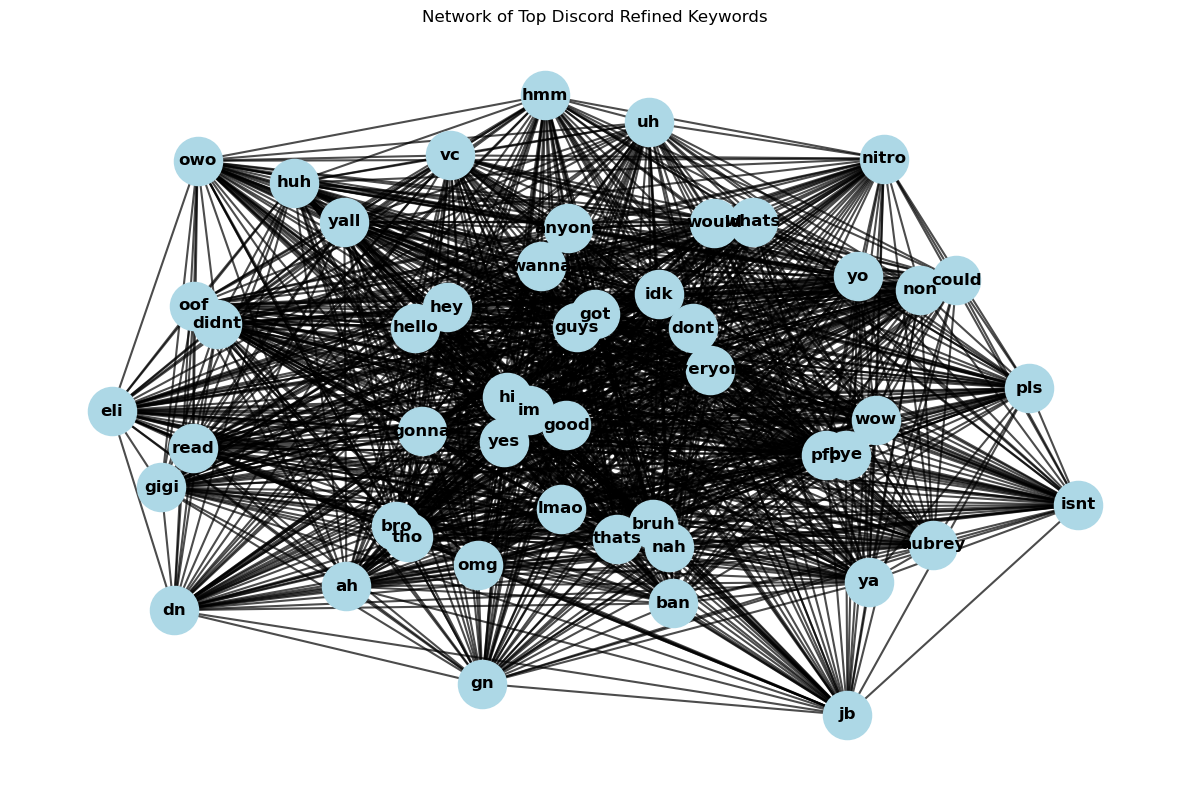

In [11]:
top_n = 50
top_words = [w for w, _ in central_keywords[:top_n]]
subgraph = G.subgraph(top_words)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, k=0.5, seed=42)
nx.draw_networkx_nodes(subgraph, pos, node_color='lightblue', node_size=1200)
nx.draw_networkx_edges(subgraph, pos, width=1.5, alpha=0.7)
nx.draw_networkx_labels(subgraph, pos, font_size=12, font_weight='bold')
plt.title("Network of Top Discord Refined Keywords")
plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
# Convert to DataFrame and export to CSV
df_scores = pd.DataFrame(central_keywords, columns=['keyword', 'pagerank_score'])

# Save to CSV (choose your path/filename as needed)
output_path = r'C:\Users\neelb\Desktop\MEDD8925 - Analyzing Data Quantitatively\MEDD8925 Discord Project\refined_keywords_pagerank_scores.csv'
df_scores.to_csv(output_path, index=False)

print(f"Exported PageRank scores for keywords to:\n{output_path}")
df_scores.head(10)

Exported PageRank scores for keywords to:
C:\Users\neelb\Desktop\MEDD8925 - Analyzing Data Quantitatively\MEDD8925 Discord Project\refined_keywords_pagerank_scores.csv


,keyword,pagerank_score
0,im,0.008786
1,yes,0.004687
2,hi,0.004465
3,good,0.004306
4,dont,0.003758
5,got,0.003293
6,hey,0.002459
7,hello,0.001976
8,guys,0.001964
9,thats,0.001935
